# Data-Science at Suburbia
At Suburbia we have been working extensively with transaction data generated from point-of-sales(pos) systems located in shops, bars, restaurants and sports-clubs. This notebook serves to explain some of the work we have been doing with data, including data quality, labelling and more. For this notebook we will focus on data from bars and restaurants, regarding so called Consumer Packaged Goods (CPG) or Fast Moving Consumer Goods (FMCG) 


## Table of Contents
1. Suburbia 
    * Acquiring
    * Combining
    * Cleaning
    * Enriching
    * Distributing
    * Data-Science
2. Suburbia's data
    * Input data
    * Processed data
    * Unbranded tagger
5. What could go wrong, 
    * data quality
6. What could go wrong, outlier detection
4. Processing data
    * Unbranded tagger
3. Simulating Suburbia's data
7. Drawing conclusions: merchant stability
8. 

# Suburbia
Suburbia acquires data from various sources which is combined, cleaned, enriched, and distributed to its customers. The aim of acquiring this data is to show economic activity by a sector, region or brand. Suburbia is interested in the Where, When and What, but never in the Who. Personal information is therefore not acquired not processed. 

## Acquiring
In particular for CPG data the data is acquired from various POS systems that are used in bars and restaurants. This data includes an date and time, the anonymized merchant, the location, a decription of the item sold and their value. The number of transactions covered runs in the Billions.

## Combining
Once the data is acquired, it is restructured in a canonical form that is used for all data that will be combined into a product. This means that for each final product a canonical form is defined, (one for cpg, one for luxury cosmetics, one for wholesale, one for financial transactions etc.). The end result is data that is all structured in a similar way, such that all further processing can be done in a generic way. Any data-source specific code is part of the combining step.

## Cleaning
Cleaning entails a large part of the processing effort, this part involves mapping the now structured data to meaningful data. As you can imagine in bars and cafe's there are many ways to indicate the same product. "coca-cola, c-cola, cola: cc-classic, can of coke" are but a few ways that coca-cola can be described. Furthermore, brands such as coca-cola have sub-brands "cherry-coke, coke-zero etc." which complicates things further. The kinds of meaningful data that we have extracted
* Brand
* Company of the brand
* Category (as tags or hierarchies)
* Location(in a canonical form)
A multitude of strategies have been used and explored including:
* Manual labeling
* Rule based labeling
* Natural Language Processing

## Enriching
Now that the data is structured and cleaned enriching is a relatively simple process of joining multiple datasets, for instance:
* location data with demographics
* date and time with weather data
* company with stock-prices

## Distributing
The data is now almost ready to ship to the customer but a few steps have to be taken to tailor the data to their needs. The data is far too big for certain customers and the tools they are used to such as excel, therefore the data needs to be pre-aggregated. More importanlty, to draw conclusions from the data first a stable subsection of the data needs to be created. The fact that a product has increased or decreased sales, in the dataset, is not enough to draw the conclusion that their sales have increased. For instance, if more merchants start using the POS systems more sales end up in our dataset, this does not mean there are more sales outside of the dataset.

## Data-Science 
We have put the most data-cience effort in the Cleaning, and Distributing of these described steps, together with the (data)quality control over the whole process. 

# Suburbia's data
We will further explain the data based on simulated data.

In [1]:
#!pip install ../

In [2]:
from analytics import merchant_stability, outlier_detection, unbranded_tagger, datasim
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [3]:
np.random.seed(seed=1)

## Input data
We start with fictive data from 2 data sources A & B that contains 5 merchants, their location and the items they sell and their price. 

In [4]:
example = datasim.get_example_merchants()
example

[{'merchant': 'merchant_1',
  'data_source': 'A',
  'location': 'DE',
  'items': [('flasche heineken bier 0.5', 4),
   ('coca-cola', 3),
   ('pizza', 12),
   ('tee mit milch', 1),
   ('milch', 3)]},
 {'merchant': 'merchant_2',
  'data_source': 'A',
  'location': 'DE',
  'items': [('bier klein', 3),
   ('kaffee mit milch', 1),
   ('kaffee mit sucker', 9),
   ('tee mit sucker', 1)]},
 {'merchant': 'merchant_3',
  'data_source': 'B',
  'location': 'NL',
  'items': [('alcoholvrijbier', 5),
   ('bepsi-cola', 2),
   ('fles wijn', 25),
   ('rode wijn', 8)]},
 {'merchant': 'merchant_4',
  'data_source': 'B',
  'location': 'NL',
  'items': [('cola can', 5), ('pizza margeritha', 9), ('fles witte', 5)]},
 {'merchant': 'merchant_5',
  'data_source': 'B',
  'location': 'BE',
  'items': [('friet', 6), ('bier stella', 7), ('witte wijn', 1)]}]

We use the fictive data from above as a basis to create a dataset, as if it was acquired and ingested. The fields have the following meaning:
* date is the date that the transaction happend
* reporting_date, since there can be a delay between the transaction date and the date the data gets delivered. The reportingdate indicates when the data has been received.
* batch is the batch or batch-date on which the delivered data was processed.
* data_source is one of the POS systems that delivers data.
* merchant is the name of the merchant as described before
* location is the location as described before
* receipt_id, many lines together make a receipt such as 2 cola, 1 hamburger is one receipt but 2 lines
* line_id, a unique identifier for each line originally supplied by the POS system
* item, a description of the item as discussed before
* unit_price, the price of a single item as discussed before
* quantity, the number of items sold e.g. 2 for 2 cola
* volume_eur, the total euro value for that line = unit_price * quantity

In [5]:
indf = datasim.create_cpg_input_df(example)
indf.head(5)

,date,reporting_date,batch,data_source,merchant,location,receipt_id,line_id,item,unit_price,quantity,volume_eur
0,0,0,0,A,merchant_1,DE,70_merchant_1,0,flasche heineken bier 0.5,4,NaN,NaN
1,0,0,0,A,merchant_1,DE,2243_merchant_2,8060,coca-cola,3,1.0,3.0
2,0,0,0,A,merchant_1,DE,293_merchant_2,8061,coca-cola,3,1.0,3.0
3,0,0,0,A,merchant_1,DE,1293_merchant_2,8062,coca-cola,3,2.0,6.0
4,0,0,0,A,merchant_1,DE,2743_merchant_2,8063,coca-cola,3,3.0,9.0


Let's have a look what this data looks like. We plot the date against total aggregates of the number of rows, the sales volume_eur and the number of items sold. There are clear peaks and valleys or seasonality representing the normal weekdays vs. the weekends. The Netherlands usually has the peak on Thursday,Friday,Saturday. While Germany has their peak a day later, Friday, Saturday, Sunday. You can think of it as the start of the series is a Monday, which is a slow day, together, with Tuesday and Wednesday, Thursday things start picking up, with the peak on Friday and Saturday, on sunday activity drops again.

Besides the scaling there is not much difference between the 3 graphs. However, we feel that first graphs which describes the number of rows is the most robust. Both volume_eur and quantity can be skewed by bad input data, highly priced items or by a issue with for instance currency conversion. We will therefore continue using the number of rows as our main graph, but it should be noted that the 3 graphs not showing the same behavior is an indication of data quality issues.

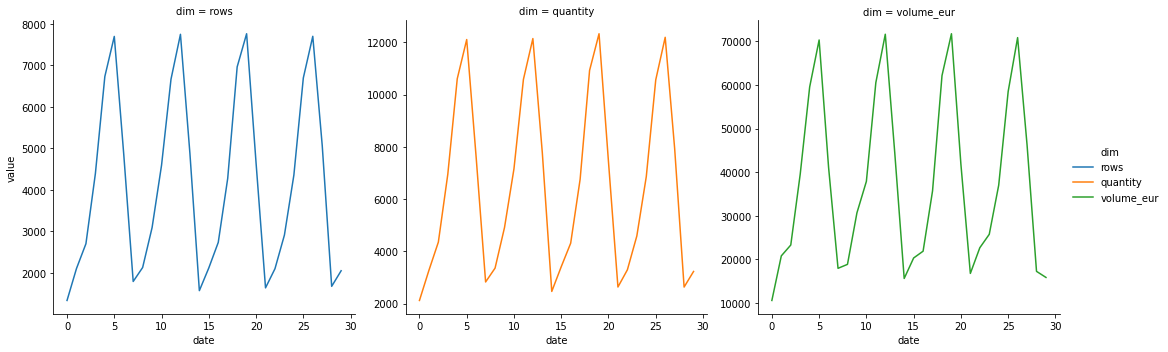

In [6]:
datasim.plot_data(indf, ['date'], ['rows', 'quantity', 'volume_eur'])

## Processed data
We saw the input data, this needs to be enriched to map the items to more meaningful data. The items are in various languages with typo's (bepsi) and abbrevations. We will use a simple mapping based on regex we map the common words to their canonical English form.

In [7]:
cat_map = datasim.get_example_category_map()
cat_map

{'bier': 'drinks/beer',
 'cola': 'drinks/cola',
 'friet': 'food/fries',
 'hamburger': 'food/hamburger',
 'kaffee': 'drinks/coffee',
 'pizza': 'food/pizza',
 'tee': 'drinks/tea'}

In this case we have a rule based mapping, but in reality such a mapping can also come from different sources such as human data-labelers. The mapping is therfore fully expanded so all different mapping sources can be combined. In this example a human labeler has reclassified alcoholfree beer as a carbonated drink. In this example we will focus continue with the regex rule based mapping.


In [8]:
expanded_cat_map = datasim.expand_map(cat_map, indf['item'].unique())
expanded_cat_map['alcoholvrijbier'] = 'drinks/carbonated'
expanded_cat_map
type(expanded_cat_map)


dict

The next step is to map the original items using this expanded_mapping, this also shows that there is a new mapped item that was not in the expanded map namely 'unknown', this is the catch-all for items that match no mapping. 

In [9]:
print(indf['item'].map(expanded_cat_map).fillna("unknown").unique())

['drinks/beer' 'drinks/cola' 'food/pizza' 'drinks/tea' 'unknown'
 'drinks/coffee' 'drinks/carbonated' 'food/fries']


In [10]:
brand_map = datasim.get_example_brand_map()
expanded_brand_map = datasim.expand_map(brand_map, indf['item'].unique())

Using similar steps we can enrich the input dataframe with our mapped items.

In [11]:
processed = datasim.clean_data(indf, expanded_cat_map, expanded_brand_map)
processed[['item', 'brand', 'category']].drop_duplicates()

,item,brand,category
0,flasche heineken bier 0.5,heineken,drinks/beer
1,coca-cola,coca-cola,drinks/cola
40,pizza,unbranded,food/pizza
41,tee mit milch,unbranded,drinks/tea
61,milch,unknown,unknown
137,bier klein,unknown,drinks/beer
161,kaffee mit milch,unknown,drinks/coffee
253,kaffee mit sucker,unbranded,drinks/coffee
336,tee mit sucker,unbranded,drinks/tea
387,alcoholvrijbier,unknown,drinks/carbonated


In [12]:
yield_cat = 1 - processed[processed['category'] == 'unknown'].count()[0]/processed.count()[0]
yield_cat    
yield_brand = 1-(processed[processed['brand'] == 'unknown'].count()[0]/processed.count()[0])
yield_unbranded = (processed[processed['brand'] == 'unbranded'].count()[0]/processed.count()[0])
yield_heineken = (processed[processed['brand'] == 'heineken'].count()[0]/processed.count()[0])

print(yield_cat, yield_brand, yield_unbranded, yield_heineken)

0.700602539789231 0.5667314817037552 0.3636843747749478 0.06449496283137687


I see that we did not label things with wijn as a category, so we will label these by hand. 

In [13]:
expanded_cat_map['wijn']='wine'
processed = datasim.clean_data(indf, expanded_cat_map, expanded_brand_map)
yield_cat = 1 - processed[processed['category'] == 'unknown'].count()[0]/processed.count()[0]
yield_cat 
# this is a mistake the proper way is
cat_map['wijn']='wine'
expanded_cat_map = datasim.expand_map(cat_map, indf['item'].unique())
processed = datasim.clean_data(indf, expanded_cat_map, expanded_brand_map)
yield_cat = 1 - processed[processed['category'] == 'unknown'].count()[0]/processed.count()[0]
yield_cat 

0.8702018868377464

Let's see if we can automate the finding of more 'unbranded' brands.

### Drawbacks of this approach
One of the drawbacks of creating a full map is that any new items that have not been seen before will not be in the full expanded mapping, eventhough there might be a rule that would match. It is therfore important to often refresh the full map with new items.
Drawbacks of categorization in a hierarchy are can be seen byby aloholfree-beer or iced-coffee making hierarchies such as alcoholic/beer or hot-drinks/coffee difficult. Tags could be used instead but have the problem of not being able to generalize to a higher category.

## Unbranded tagger


In [14]:
mask = processed['brand'] == 'unbranded'
unbranded = processed.loc[mask, 'item'].drop_duplicates()
mask = processed['brand'] == 'unknown'
unknown = processed.loc[mask, 'item'].drop_duplicates()
print("\n".join(list(unbranded)),'\n++++++\n',"\n".join(list(unknown)))

to_label_unbranded = unbranded_tagger.get_unbranded(
    to_label=unknown,
    unbranded=unbranded,
    tokens_to_exclude=['red', 'bull'],  # for brands comprised of common words 
    min_unbranded_rows=1,
)
print('Items labeled as "unbranded":\n')
for item in unknown[to_label_unbranded]:
    print(item)

pizza
tee mit milch
kaffee mit sucker
tee mit sucker
rode wijn
pizza margeritha
fles witte 
++++++
 milch
bier klein
kaffee mit milch
alcoholvrijbier
bepsi-cola
fles wijn
cola can
friet
witte wijn
Items labeled as "unbranded":

milch
kaffee mit milch
fles wijn
witte wijn


In [15]:
for item in unknown[to_label_unbranded]:
    expanded_brand_map[item]='unbranded'
processed = datasim.clean_data(indf, expanded_cat_map, expanded_brand_map)
yield_cat = 1 - processed[processed['category'] == 'unknown'].count()[0]/processed.count()[0]
yield_brand = 1-(processed[processed['brand'] == 'unknown'].count()[0]/processed.count()[0])
yield_unbranded = (processed[processed['brand'] == 'unbranded'].count()[0]/processed.count()[0])
print(yield_cat, yield_brand, yield_unbranded)

0.8702018868377464 0.7679301597970729 0.5648830528682655


In [16]:
datasim.create_cpg_df(example, cat_map, brand_map)

,date,reporting_date,batch,data_source,merchant,location,receipt_id,line_id,item,unit_price,quantity,volume_eur,category,brand
0,0,0,0,A,merchant_1,DE,1060_merchant_1,0,flasche heineken bier 0.5,4,1.0,4.0,drinks/beer,heineken
1,0,0,0,A,merchant_1,DE,2060_merchant_1,1,flasche heineken bier 0.5,4,3.0,12.0,drinks/beer,heineken
2,0,0,0,A,merchant_1,DE,1580_merchant_1,2,flasche heineken bier 0.5,4,5.0,20.0,drinks/beer,heineken
3,0,0,0,A,merchant_1,DE,2170_merchant_1,3,flasche heineken bier 0.5,4,1.0,4.0,drinks/beer,heineken
4,0,0,0,A,merchant_1,DE,1990_merchant_1,4,flasche heineken bier 0.5,4,1.0,4.0,drinks/beer,heineken
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126251,29,29,35,B,merchant_5,BE,5329_merchant_5,126251,witte wijn,1,1.0,1.0,wine,unknown
126252,29,29,35,B,merchant_5,BE,7429_merchant_5,126252,witte wijn,1,1.0,1.0,wine,unknown
126253,29,29,35,B,merchant_5,BE,11229_merchant_5,126253,witte wijn,1,1.0,1.0,wine,unknown
126254,29,29,35,B,merchant_5,BE,11629_merchant_5,126254,witte wijn,1,1.0,1.0,wine,unknown
